# Projet : Essai de prédiction de l'état de fatigue par Deep Learning

In [2]:
from alphawaves.dataset import AlphaWaves
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\alexc\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 1. Premier pas avec la Data Base

In [4]:
# Le dataset
dataset = AlphaWaves()

In [5]:
# Charger les informations sur les sujets (étiquettes)
demoh = pd.read_csv("demographic_header.csv", sep=",", header=None)
headers = demoh.iloc[0].tolist()  # transforme la ligne en liste
demog = pd.read_csv("demographic.csv", sep=",", header=None)
demog.columns = headers
print(demog.head())

   Subject  IsMan  Age  Fatigue
0        1      1   27        5
1        2      1   23        0
2        3      1   44        2
3        4      1   26        2
4        5      1   26        4


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\alexc\AppData\Local\Temp\ipykernel_71784\2291201627.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  brut.compute_psd(fmin=8, fmax=12).plot() # ondes alphas
C:\Users\alexc\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


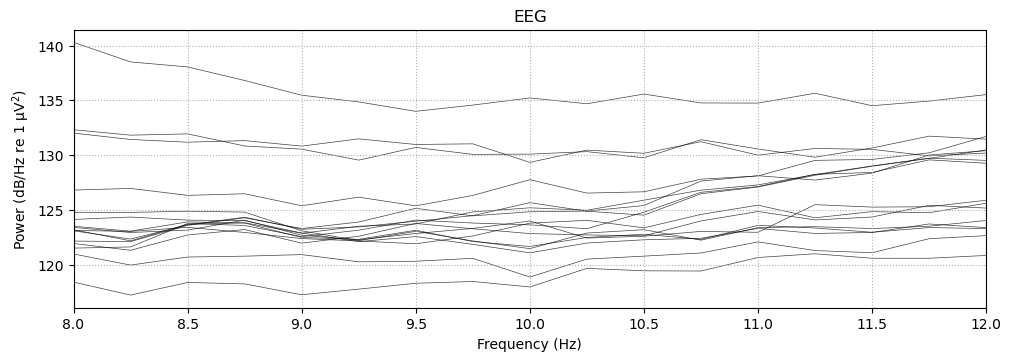

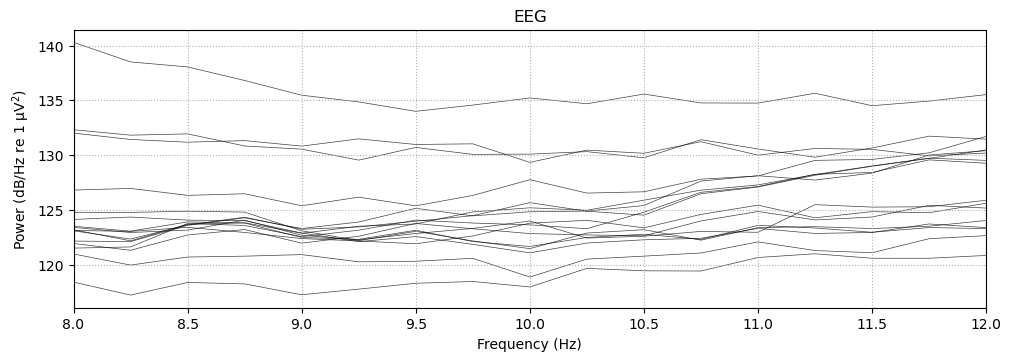

In [6]:
# Visualisation d'un sujet
subject = dataset.subject_list[0]
brut = dataset._get_single_subject_data(subject)
brut.compute_psd(fmin=8, fmax=12).plot() # ondes alphas

In [7]:
# Comme pas de localisation (x,y,z) on prend le montage 10-20 worldwide
montage = mne.channels.make_standard_montage("standard_1020")
brut.set_montage(montage, match_case=False, on_missing="ignore")

<RawArray | 17 x 119808 (234.0 s), ~15.6 MiB, data loaded>

In [8]:
# Events
events = mne.find_events(brut, stim_channel='stim')
print(events)
event_id = {'closed': 1, 'open': 2}

Finding events on: stim
10 events found on stim channel stim
Event IDs: [1 2]
[[ 35511      0      1]
 [ 45179      0      2]
 [ 53413      0      1]
 [ 61886      0      2]
 [ 69812      0      1]
 [ 78140      0      2]
 [ 85802      0      1]
 [ 93556      0      2]
 [101416      0      1]
 [109193      0      2]]


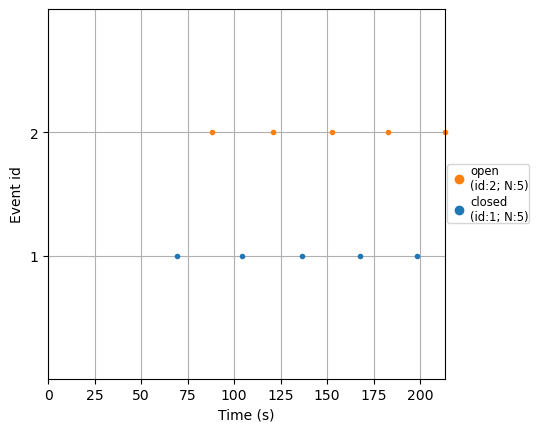

In [9]:
# Visualisation des events
fig = mne.viz.plot_events(
    events, event_id=event_id, sfreq=brut.info["sfreq"], first_samp=brut.first_samp
)

## 2. Prétraitement des signaux

In [11]:
# Électrodes pariéto-occipitales d'AlphaWaves
PO_CHANNELS = ["P7","P3","Pz","P4","P8","O1","Oz","O2"]

def pretraite(dataset, subject:int=0,
                           fmin:float=5., fmax:float=40., sfreq:float=128.,
                           tmin:float=2.0, tmax:float=8.0):
    """
    Prétraitement du signal EEG

    Paramètres :
    ------
    dataset : alphawaves.AlphaWaves
        Le dataset complet contenant tous les sujets.
    subject : int
        Index du sujet dans dataset.subject_list (par défaut 0).
    fmin : float
        Fréquence basse du filtre passe-bande (Hz).
    fmax : float
        Fréquence haute du filtre passe-bande (Hz).
    sfreq : float
        Fréquence cible après rééchantillonnage (Hz).
    tmin : float
        Temps de début de l’epoch par rapport à l’événement (s).
    tmax : float
        Temps de fin de l’epoch par rapport à l’événement (s).

    Retourne :
    ------
    mne.Epochs (n_epochs, n_channels, n_times)
    """
    sid = dataset.subject_list[subject]
    raw = dataset._get_single_subject_data(sid).copy().load_data()

    # 1) Débruitage secteur + bande utile
    raw.notch_filter(freqs=[50.0], verbose=False)
    raw.filter(fmin, fmax, verbose=False)

    # 2) Fréquence d’échantillonnage
    raw.resample(sfreq, verbose=False)

    # 3) Référencement moyenne (CAR)
    mne.set_eeg_reference(raw, 'average', projection=False, verbose=False)

    # 4) Créations des epochs 'closed'
    events = mne.find_events(raw, stim_channel='stim', shortest_event=1, verbose=False)
    epochs_closed = mne.Epochs(
        raw, events, event_id={'closed': 1},
        tmin=tmin, tmax=tmax,
        baseline=None, preload=True, verbose=False,
        picks='eeg'
    )

    # 5) Ne conserver que les canaux pariéto-occipitaux (ceux qui existent chez ce sujet)
    keep = [ch for ch in PO_CHANNELS if ch in epochs_closed.ch_names]
    epochs_closed = epochs_closed.pick(keep)

    return epochs_closed

In [12]:
# Test
epochs = pretraite(dataset, subject=0)
X = epochs.get_data()
print(50*'-')
print(X.shape, epochs.ch_names)

--------------------------------------------------
(5, 8, 769) ['P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


In [13]:
def epochs_to_Xy_keras(epochs, demog, subject_id: int,
                       normalize: bool = True,
                       keras_time_last: bool = True,
                       win_sec: float | None = None,
                       stride_sec: float | None = None):
    """
    Convertit des epochs 'closed' (déjà filtrés/pickés) en (X, y) pour Keras.

    Paramètres
    ------
    epochs : mne.Epochs
        Epochs yeux fermés issus de pretraite.
    demog : pandas.DataFrame
        DataFrame démographique avec les colonnes 'Subject' et 'Fatigue'.
    subject_id : int
        ID numérique du sujet.
    normalize : bool
        Z-score par canal sur toutes les epochs du sujet.
    keras_time_last : bool
        Si True -> sortie (n_samples, n_times, n_channels) (format Keras).
    win_sec, stride_sec : float | None
        Si fournis, re-fenêtre chaque epoch en fenêtres glissantes
        de durée win_sec et pas stride_sec (en secondes).

    Retourne :
    ------
    X : np.ndarray
        (n_samples, n_times, n_channels) si keras_time_last=True,
        sinon (n_samples, n_channels, n_times). dtype float32.
    y : np.ndarray
        (n_samples,), score de fatigue du sujet (float32).
    """
    # 1) Récup données des epochs
    X = epochs.get_data()  # (n_epochs, n_channels, n_times)

    # 2) Normalisation par canal (sur toutes les epochs du sujet)
    if normalize:
        mean = X.mean(axis=(0, 2), keepdims=True)  # (1, ch, 1)
        std  = X.std(axis=(0, 2), keepdims=True)
        X = (X - mean) / (std + 1e-8)

    # 3) Re-fenêtrage optionnel
    if (win_sec is not None) and (stride_sec is not None):
        sf = epochs.info['sfreq']
        win = int(win_sec * sf)
        hop = int(stride_sec * sf)
        segs = []
        for ep in X:  # ep: (ch, time)
            N = ep.shape[1]
            for s in range(0, N - win + 1, hop):
                segs.append(ep[:, s:s+win])
        X = np.stack(segs, axis=0)  # (n_win_total, ch, win)

    # 4) Étiquette fatigue (unique pour le sujet)
    fatigue = float(demog.loc[demog['Subject'].astype(int) == int(subject_id), 'Fatigue'].values[0])
    y = np.full((X.shape[0],), fatigue, dtype=np.float32)

    # 5) Format Keras
    if keras_time_last:
        X = np.transpose(X, (0, 2, 1))  # -> (n, time, ch)
    X = X.astype(np.float32)

    return X, y


In [14]:
X_all, y_all, groups = [], [], []

for i, sid in enumerate(dataset.subject_list):
    # 1) epochs "closed" prétraités (pariéto-occipitaux)
    epochs = pretraite(dataset, subject=i)

    # 2) ID numérique du sujet (ex: "subject_01" -> 1)
    for i, sid in enumerate(dataset.subject_list):
      epochs = pretraite(dataset, subject=i)
      sid_int = int(str(sid).split('_')[-1])  # <-- fix ici
      X_i, y_i = epochs_to_Xy_keras(epochs, demog, subject_id=sid_int,
                                    normalize=True, keras_time_last=True,)
      X_all.append(X_i); y_all.append(y_i); groups.extend([sid_int]*len(y_i))

    # 3) epochs -> (X, y) prêts Keras (time-last)
    X_i, y_i = epochs_to_Xy_keras(
        epochs, demog, subject_id=sid_int,
        normalize=True, keras_time_last=True,
    )

    X_all.append(X_i)
    y_all.append(y_i)
    groups.extend([sid_int] * len(y_i))

X_all = np.vstack(X_all).astype(np.float32)  # (N, time, ch)
y_all  = np.concatenate(y_all).astype(np.float32)  # (N,)
groups = np.array(groups, dtype=int)  # (N,)

print("X_all:", X_all.shape, "| y_all:", y_all.shape, "| groups:", groups.shape)

X_all: (1900, 769, 8) | y_all: (1900,) | groups: (1900,)


In [15]:
# sujets uniques
subjects = np.unique(groups)
# split simple: 70% train, 15% val, 15% test (par sujet)
n_subj = len(subjects)
n_train = int(0.7 * n_subj)
n_val   = int(0.15 * n_subj)
perm = subjects  # si tu veux randomiser: np.random.RandomState(42).permutation(subjects)

train_subj = perm[:n_train]
val_subj   = perm[n_train:n_train+n_val]
test_subj  = perm[n_train+n_val:]

def mask_from_subj(gs, subj_list):
    sset = set(subj_list.tolist() if isinstance(subj_list, np.ndarray) else subj_list)
    return np.array([g in sset for g in gs], dtype=bool)

m_tr = mask_from_subj(groups, train_subj)
m_va = mask_from_subj(groups, val_subj)
m_te = mask_from_subj(groups, test_subj)

X_tr, y_tr = X_all[m_tr], y_all[m_tr]
X_va, y_va = X_all[m_va], y_all[m_va]
X_te, y_te = X_all[m_te], y_all[m_te]
g_tr, g_va, g_te = groups[m_tr], groups[m_va], groups[m_te]

print("Train:", X_tr.shape, "| Val:", X_va.shape, "| Test:", X_te.shape)
print("Train subjects:", np.unique(g_tr))
print("Val subjects  :", np.unique(g_va))
print("Test subjects :", np.unique(g_te))

Train: (1235, 769, 8) | Val: (190, 769, 8) | Test: (475, 769, 8)
Train subjects: [ 1  2  3  4  5  6  8  9 10 11 12 13 14]
Val subjects  : [15 16]
Test subjects : [17 18 19 20]


In [16]:
# Input shape = (time, ch)
time_steps = X_tr.shape[1]
n_ch = X_tr.shape[2]

def build_model(time_steps, n_ch):
    inp = keras.Input(shape=(time_steps, n_ch))
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)  # régression fatigue (1..10)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="mse",
                  metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return model

model = build_model(time_steps, n_ch)
model.summary()

cb = [
    keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=5, min_lr=1e-5),
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=100,
    batch_size=64,
    callbacks=cb,
    verbose=1
)

# ----- Évaluation fenêtre-par-fenêtre -----
win_preds = model.predict(X_te).squeeze()
win_mae = np.mean(np.abs(win_preds - y_te))
print(f"Window-level MAE: {win_mae:.3f}")

# ----- Évaluation SUJET (moyenne des fenêtres par sujet) -----
df = pd.DataFrame({"pred": win_preds, "true": y_te, "subj": g_te})
subj_pred = df.groupby("subj")["pred"].mean()
subj_true = df.groupby("subj")["true"].mean()
subj_mae = np.mean(np.abs(subj_pred - subj_true))
print(f"Subject-level MAE: {subj_mae:.3f}")

# tableau comparatif par sujet
res = pd.DataFrame({"pred": subj_pred.round(2), "true": subj_true.round(2)})
res["abs_err"] = (res["pred"] - res["true"]).abs()
print("\nPar sujet (moyenne des fenêtres):")
print(res.sort_values("abs_err"))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 769, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 769, 32)             │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 769, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 769, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,705 (112.13 KB)

 Trainable params: 28,705 (112.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 11.3221 - mae: 2.7138 - val_loss: 2.4491 - val_mae: 1.5504 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 5.7111 - mae: 2.0404 - val_loss: 2.6871 - val_mae: 1.5658 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 5.5079 - mae: 2.0381 - val_loss: 2.8264 - val_mae: 1.5827 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 5.1994 - mae: 2.0073 - val_loss: 2.8374 - val_mae: 1.6012 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 5.0118 - mae: 1.9705 - val_loss: 3.2721 - val_mae: 1.6449 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 4.5853 - mae: 1.8796 - val_loss: 4.2288 - val_mae: 1.7403 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 4.4732 - mae: 1.8353 - val_loss: 5.1440 - val_mae: 1.8156 - learning_rate: 5.0000e-04


In [17]:
# Sauvegarde du dataset construit
np.savez_compressed(
    "alphawaves_Xy_keras.npz",
    X=X_all, y=y_all, groups=groups,
    params=dict(fmin=FMIN, fmax=FMAX, sfreq=SFREQ, tmin=TMIN, tmax=TMAX,
                win_sec=WIN_SEC, stride_sec=STRIDE_SEC)
)
print("✅ Sauvegardé: alphawaves_Xy_keras.npz")

# Sauvegarde du modèle Keras
model.save("model_fatigue_conv1d.h5")
print("✅ Sauvegardé: model_fatigue_conv1d.h5")


NameError: name 'FMIN' is not defined

In [ ]:
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend()

# MAE
plt.subplot(1,2,2)
plt.plot(history.history["mae"], label="train")
plt.plot(history.history["val_mae"], label="val")
plt.title("MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Prédictions fenêtre-par-fenêtre déjà faites ci-dessus:
# win_preds = model.predict(X_te).squeeze()
# y_te, g_te déjà définis

df = pd.DataFrame({"pred": win_preds, "true": y_te, "subj": g_te})
subj_pred = df.groupby("subj")["pred"].mean()
subj_true = df.groupby("subj")["true"].mean()
res = pd.DataFrame({"pred": subj_pred, "true": subj_true})
res["abs_err"] = (res["pred"] - res["true"]).abs()
print("Par sujet (moyenne des fenêtres):")
print(res.sort_values("abs_err").round(2))

# Scatter vrai vs prédit (niveau sujet)
plt.figure(figsize=(5,5))
plt.scatter(res["true"], res["pred"])
xy = np.array([res["true"].min(), res["true"].max()])
plt.plot(xy, xy, linestyle="--")
plt.xlabel("Fatigue vraie (sujet)")
plt.ylabel("Fatigue prédite (sujet)")
plt.title("Vrai vs Prédit par sujet")
plt.grid(True)
plt.show()

subj_mae = res["abs_err"].mean()
print(f"Subject-level MAE: {subj_mae:.3f}")

In [ ]:
# Regrouper les fenêtres par vraie fatigue (arrondie si besoin)
bins = pd.DataFrame({"true": y_te, "pred": win_preds})
bins["true_rounded"] = bins["true"].round()  # parce que cibles 0..10 entières

err_by_level = bins.groupby("true_rounded").apply(
    lambda d: pd.Series({
        "n": len(d),
        "mae": np.mean(np.abs(d["pred"] - d["true"]))
    })
).sort_index()

print("MAE par niveau de fatigue (fenêtre):")
print(err_by_level.round(3))

In [ ]:
def predict_subject_fatigue(dataset, demog, subject_idx, model,
                            normalize=True, keras_time_last=True):
    # 1) prétraiter → epochs fermés (tes PO channels)
    epochs = pretraite(dataset, subject=subject_idx)
    # 2) (X,y) pour ce sujet (y inutile ici, on garde pour contrôle)
    sid = dataset.subject_list[subject_idx]
    sid_int = int(str(sid).split('_')[-1])
    X, y = epochs_to_Xy_keras(epochs, demog, subject_id=sid_int,
                              normalize=normalize, keras_time_last=keras_time_last,
                              win_sec=win_sec, stride_sec=stride_sec)
    # 3) prédictions fenêtre-par-fenêtre + moyenne sujet
    preds = model.predict(X).squeeze()
    return float(np.mean(preds)), preds

# Exemple d’usage sur le premier sujet du split test
subj_test = int(np.unique(g_te)[0])         # ex: 17
pred_mean, preds_win = predict_subject_fatigue(dataset, demog,
                                               subject_idx=subj_test-1,
                                               model=model)
print(f"Sujet {subj_test} → prédiction moyenne: {pred_mean:.2f}")